In [21]:
#Inital Imports
import numpy as np
import networkx as nx
import pandas as pd
import gurobipy as gb
from gurobipy import GRB

## Step 1: Parse Network Topology and load Demands

In [22]:
# load data fram using pandas for topology
df = pd.read_csv("data/ATT/topology.txt", delimiter=r"\s+")
print(df)

# Create Graph

G = nx.from_pandas_edgelist(df, 'from_node', 'to_node', ['capacity', 'prob_failure'])

     to_node  from_node  capacity  prob_failure
0          9          2   1200000         0.001
1          9         22   1200000         0.001
2          9          8   1200000         0.001
3          9         13   1200000         0.001
4          9          3   1200000         0.001
..       ...        ...       ...           ...
107       21         17   1200000         0.001
108       21         15   1200000         0.001
109       24         22   1200000         0.001
110       24         23   1200000         0.001
111       24         12   1200000         0.001

[112 rows x 4 columns]


## Step 2: Visualize Graph

{(2, 9): 1200000, (2, 3): 1200000, (2, 6): 1200000, (2, 17): 1200000, (2, 16): 1200000, (2, 25): 1200000, (2, 21): 1200000, (2, 15): 1200000, (2, 20): 1200000, (9, 22): 1200000, (9, 8): 1200000, (9, 13): 1200000, (9, 3): 1200000, (9, 16): 1200000, (9, 5): 1200000, (22, 13): 1200000, (22, 17): 1200000, (22, 23): 1200000, (22, 24): 1200000, (22, 21): 1200000, (8, 13): 1200000, (8, 3): 1200000, (8, 5): 1200000, (13, 5): 1200000, (13, 11): 1200000, (13, 17): 1200000, (13, 12): 1200000, (13, 16): 1200000, (13, 10): 1200000, (13, 15): 1200000, (3, 6): 1200000, (16, 17): 1200000, (16, 15): 1200000, (5, 7): 1200000, (5, 4): 1200000, (5, 14): 1200000, (6, 1): 1200000, (6, 25): 1200000, (6, 7): 1200000, (17, 19): 1200000, (17, 18): 1200000, (17, 21): 1200000, (17, 15): 1200000, (17, 20): 1200000, (25, 1): 1200000, (25, 7): 1200000, (21, 18): 1200000, (21, 15): 1200000, (20, 19): 1200000, (7, 4): 1200000, (14, 11): 1200000, (14, 10): 1200000, (11, 12): 1200000, (11, 10): 1200000, (12, 24): 120000

{(2, 3): Text(0.1028200718734888, -0.2797567266135428, '1200000'),
 (2, 6): Text(0.12862760953506272, -0.4259390622387067, '1200000'),
 (2, 9): Text(0.084579397048089, -0.12021300809918138, '1200000'),
 (2, 15): Text(0.2333556554450843, -0.0706353791355397, '1200000'),
 (2, 16): Text(0.1718674469714006, -0.08192935566386779, '1200000'),
 (2, 17): Text(0.3072687623616369, -0.03970765666685881, '1200000'),
 (2, 20): Text(0.43460863405601113, -0.14572601097531335, '1200000'),
 (2, 21): Text(0.35680446152863454, -0.047784962975121484, '1200000'),
 (2, 25): Text(0.1644482022125711, -0.4701053955599235, '1200000'),
 (3, 6): Text(-0.009511058253113868, -0.4841845458588623, '1200000'),
 (5, 4): Text(-0.5421387244471947, -0.36942186083896, '1200000'),
 (5, 7): Text(-0.38139603259763033, -0.40178557207477794, '1200000'),
 (5, 14): Text(-0.5970467803152673, -0.02971922100781761, '1200000'),
 (6, 1): Text(0.0567611690434379, -0.8151834407420131, '1200000'),
 (6, 7): Text(-0.14835199847162386, -0.6

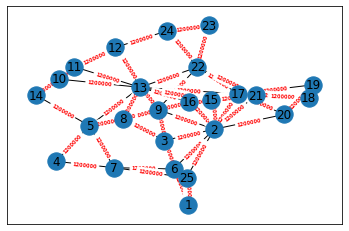

In [23]:
#Draw loaded graph
# spring layout prevents graph from
# becoming too clustered
layout = nx.spring_layout(G)
# draw node, edges, and labels sperately
nx.draw_networkx_labels(G, pos=layout )
nx.draw_networkx_nodes(G, pos=layout) 
nx.draw_networkx_edges(G, pos=layout)
# only add capacities as labels
edge_labels = dict([((source, dest), G[source][dest]["capacity"]) for source, dest in G.edges])
print(edge_labels)
nx.draw_networkx_edge_labels(G, pos= layout, edge_labels= edge_labels,font_color="red", font_weight="bold", font_size = 5)

## Step 3: Parse Traffic Demands

In [24]:
demands = np.loadtxt("data/ATT/demand.txt")
demands_dict = {}
n = len(G.nodes())
i = 0
for t in demands:
    src = 1
    dest = 1
    for y in t:
        demands_dict[(i,src,dest)] = y
        if dest == n:
            dest = 0
            src += 1
        else:
            dest +=1
    i+=1
time = i
demands_dict

{(0, 1, 1): 6543.408364,
 (0, 1, 2): 2593.426585,
 (0, 1, 3): 13353.45958,
 (0, 1, 4): 3753.163709,
 (0, 1, 5): 1636.843883,
 (0, 1, 6): 7074.178405,
 (0, 1, 7): 5327.500337,
 (0, 1, 8): 11399.420783,
 (0, 1, 9): 1408.264286,
 (0, 1, 10): 4934.96452,
 (0, 1, 11): 15741.801504,
 (0, 1, 12): 49688.994885,
 (0, 1, 13): 747.073868,
 (0, 1, 14): 29622.790672,
 (0, 1, 15): 5373.333487,
 (0, 1, 16): 16550.998545,
 (0, 1, 17): 2028.071557,
 (0, 1, 18): 6088.208035,
 (0, 1, 19): 1615.715696,
 (0, 1, 20): 11637.764782,
 (0, 1, 21): 8755.448494,
 (0, 1, 22): 2479.975185,
 (0, 1, 23): 982.635976,
 (0, 1, 24): 33341.804091,
 (0, 1, 25): 9053.148028,
 (0, 2, 0): 1574.251068,
 (0, 2, 1): 957.789644,
 (0, 2, 2): 4275.116025,
 (0, 2, 3): 1118.74365,
 (0, 2, 4): 524.036297,
 (0, 2, 5): 2108.672253,
 (0, 2, 6): 1588.022169,
 (0, 2, 7): 3397.941207,
 (0, 2, 8): 419.775648,
 (0, 2, 9): 1471.015029,
 (0, 2, 10): 5039.744754,
 (0, 2, 11): 15907.953817,
 (0, 2, 12): 239.176031,
 (0, 2, 13): 9483.749612,
 (0, 

## Step 4: Traffic Algorithm: Maximize Total Throughput


In [25]:
#TODO
#Decision variables:

#edge current flows and capacities
flow_matrix = {}
capacity_matrix = {}
for key, value in edge_labels:
    flow_matrix[key] = 0
    capacity_matrix[key] = value



# edge_time, demand = demands_dict


#If flow is 0, edge is not active

#for each edge in edges: set in some array/matrix all the possible edges

#----------------------------

#Optimization function:

#Sum of the flows of all of the edges

model = gb.Model()
print(edge_labels)

edges, edge2, capacities = edge_labels
print(edges)

flow = model.addVars(edges, obj=capacities, name="flow")

model.setObjective(gb.quicksum(flow_matrix.values()), gb.GRB_MAXIMIZE)


#----------------------------

#Constraints: 

#Capacity check: Flow on edge (u, v) <= capacity (u, v)

#Demand reqs: flow into node u = demand u: f_in(u) - f_out(u) = demand(u) https://www.cs.cmu.edu/~ckingsf/bioinfo-lectures/flowext.pdf

#Conservation: Flow into node u = flow out of node u???

# model.addConstr(flow_matrix[(t, u, v)] <= capacity_matrix[t, u, v]])
# model.addConstr(flow_in[t, u] - flow_out[t, u])

{(2, 9): 1200000, (2, 3): 1200000, (2, 6): 1200000, (2, 17): 1200000, (2, 16): 1200000, (2, 25): 1200000, (2, 21): 1200000, (2, 15): 1200000, (2, 20): 1200000, (9, 22): 1200000, (9, 8): 1200000, (9, 13): 1200000, (9, 3): 1200000, (9, 16): 1200000, (9, 5): 1200000, (22, 13): 1200000, (22, 17): 1200000, (22, 23): 1200000, (22, 24): 1200000, (22, 21): 1200000, (8, 13): 1200000, (8, 3): 1200000, (8, 5): 1200000, (13, 5): 1200000, (13, 11): 1200000, (13, 17): 1200000, (13, 12): 1200000, (13, 16): 1200000, (13, 10): 1200000, (13, 15): 1200000, (3, 6): 1200000, (16, 17): 1200000, (16, 15): 1200000, (5, 7): 1200000, (5, 4): 1200000, (5, 14): 1200000, (6, 1): 1200000, (6, 25): 1200000, (6, 7): 1200000, (17, 19): 1200000, (17, 18): 1200000, (17, 21): 1200000, (17, 15): 1200000, (17, 20): 1200000, (25, 1): 1200000, (25, 7): 1200000, (21, 18): 1200000, (21, 15): 1200000, (20, 19): 1200000, (7, 4): 1200000, (14, 11): 1200000, (14, 10): 1200000, (11, 12): 1200000, (11, 10): 1200000, (12, 24): 120000

ValueError: too many values to unpack (expected 3)

In [27]:
m = gb.Model("step4")
traffic = {}
for (t, i, j) in demands_dict:
    if (i, j) in edge_labels:
        traffic[(t, i, j)] = m.addVar(ub=edge_labels[(i, j)], name=f"traffic_{i}_{j}_{t}")
    else:
        traffic[(t, i, j)] = m.addVar(ub=0, name=f"traffic_{i}_{j}_{t}")
        
for (t, i, j) in demands_dict:
    print((t, i, j))
    m.addConstr(gb.quicksum((traffic[(t, i, j)] - traffic[(t, j, i)]) for (t, i, j) in demands_dict) == demands_dict[(t, i , j)])
for (i, j) in edge_labels:
    for t in range(1, time + 1):
        m.addConstr(gb.quicksum(traffic[(k, i, j)] for k in range(1, t + 1)) <= edge_labels[(i, j)])

m.setObjective(gb.quicksum(traffic[(t, i, j)] for (t, i, j) in demands_dict), GRB.MAXIMIZE)

m.optimize()

if m.status == GRB.OPTIMAL:
    print('Optimal traffic allocation')

(0, 1, 1)


KeyError: (0, 0, 2)

## Step 5: Traffic Algorithm: Maximize Link Utilization

In [ ]:
demand = {}
for (i , s, d) in demands_dict:
    demand[(s, d)] = demands_dict[(i, s, d)]
model2 = gb.Model('step5')
x = {}
for u, v in edge_labels:
    x[u, v] = model2.addVar(vtype=GRB.CONTINUOUS)



## Step 6: Compare Algorithms

TODO

## Step 7 (EXTRA CREDIT): Scaling with Topology Size